In [55]:
import pandas as pd
import numpy as np
import sys
import os
import configparser
import skimage

config = configparser.ConfigParser()
config.read('../../config.ini')
vg_json = config['PATHS']['vg-json']
vg_json_export = config['PATHS']['json-export']
image_dir = config['PATHS']['vg-images']

source_dir = vg_json_export + 'extracted_data/'

sys.path.append(os.path.abspath('../../Module'))
import preprocessing
import visualize

In [2]:
w2c_datasets = np.load(vg_json_export+'w2c_data.npz')

In [3]:
w2c_datasets.files

['w2c', 'chip_w2c', 'chip_w2c_lab']

In [4]:
def color_pixelwise(img, w2c, bb=False):
    # vgl. Datei im2c.m aus http://lear.inrialpes.fr/people/vandeweijer/code/ColorNaming.tar
    # Input: Bild-Pfad und w2c-Matrix (Mapping von RGB-Werten zu Farbnamen)
    
    # Bild als Array
    img = skimage.io.imread(img)
    
    # für Grayscale-Bilder
    if len(img.shape) < 3:
        img = skimage.color.gray2rgb(img, alpha=None)
    
    # img-Array slicen, falls Bounding Box gegeben
    if bb:
        if type(bb) == list:
            bb ={
                'h' : bb[0],
                'w' : bb[1],
                'x' : bb[2],
                'y' : bb[3]
            }
        img = img[bb['y']:bb['y']+bb['h'], bb['x']:bb['x']+bb['w']]
    
    # Kanäle trennen
    RR=img[:,:,0]
    GG=img[:,:,1]
    BB=img[:,:,2]
    
    # Index-Array erstellen: Ein Index-Wert pro Pixel
    index_img = np.array(
        # R-Werte (32 Bins)
        np.floor(RR/8)+
        # G-Werte (32 Bins)
        32* np.floor(GG/8)+
        # B-Werte (32 Bins)
        32*32*np.floor(BB/8)
    )
    # Array für Wahrscheinlichkeitsverteilung über Farbklassen initialisieren
    clr_distribution = np.zeros(11)
    
    # Für jeden Index-Wert die jeweils assoziierte Wahrscheinlichkeitsverteilung zu clr_distribution addieren
    for pxl_index in index_img.ravel():
        clr_distribution = clr_distribution + w2c[int(pxl_index)][3:]
        
    # clr_distribution normalisieren
    clr_distribution = clr_distribution / len(index_img.ravel())
    
    return clr_distribution

def rows_pixelwise_classification(row,  w2c):
    bb = {
        'h' : row.bb_h,
        'w' : row.bb_w,
        'x' : row.bb_x,
        'y' : row.bb_y
    }
    img_path = image_dir + str(row.image_id) + '.jpg'
    return (np.append(row.Index, color_pixelwise(img_path, w2c, bb)))

def dataframe_pixelwise_classification(df, w2c):
    results = np.empty((0,12))
    for row in df.itertuples():
        res = rows_pixelwise_classification(row, w2c)
        res = np.reshape(res, (1,12))
        results = np.append(results, res, axis=0)
    return results

In [10]:
objects = pd.read_csv(source_dir+"all_objects.csv", index_col=0)

# Color Diagnostic Objects erhalten
###################################

print('get frequent diagnostic objects')

frequent_objects, _, _ = preprocessing.freq_cdo_cno(objects, num_cdos=100, num_cnos=100, min_num=100)

# Data Frame mit frequenten Objekten

frequent_objects_df = objects\
    .loc[objects.object_name.isin(frequent_objects)]

# Splitten in Train/Test/Dev-Sets
print ('create train and test data set')

# Indizes der jeweiligen Splits erhalten durch Intersection mit frequent_objects_df
train_index = pd.read_csv(source_dir+"train_df.csv", index_col=0).index.intersection(frequent_objects_df.index)
test_index = pd.read_csv(source_dir+"test_df.csv", index_col=0).index.intersection(frequent_objects_df.index)
dev_index = pd.read_csv(source_dir+"dev_df.csv", index_col=0).index.intersection(frequent_objects_df.index)

# DataFrames für Train/Test/Dev-Splits erstellen
train_df = frequent_objects_df.loc[train_index]
test_df = frequent_objects_df.loc[test_index]
dev_df = frequent_objects_df.loc[dev_index]

print ('Train set shape:', train_df.shape)
print ('Test set shape:', test_df.shape)
print ('Dev set shape:', dev_df.shape)

get frequent diagnostic objects
create train and test data set
Train set shape: (538775, 8)
Test set shape: (153856, 8)
Dev set shape: (77048, 8)


In [5]:
url = 'https://upload.wikimedia.org/wikipedia/commons/9/9c/Ceruleanblue.jpg'
color_pixelwise(url, w2c_datasets['w2c'])

array([6.71900e-03, 8.66972e-01, 1.13900e-03, 9.53300e-03, 1.50400e-03,
       8.18200e-03, 2.72000e-04, 5.23000e-02, 2.96090e-02, 7.83500e-03,
       1.59350e-02])

In [159]:
dataframe_pixelwise_classification(dev_df.head(10), w2c_datasets['w2c'])

10

In [33]:
url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/f/f1/A_tiny_branch_of_a_cherry_blossom_tree_%288651135027%29.jpg/800px-A_tiny_branch_of_a_cherry_blossom_tree_%288651135027%29.jpg'
url2 = 'https://upload.wikimedia.org/wikipedia/commons/thumb/b/b6/5GF2g_img286_DONE_treated_1946_April.jpg/84px-5GF2g_img286_DONE_treated_1946_April.jpg'
dist = color_pixelwise(url, w2c_datasets['chip_w2c_lab'])
dict(zip(dist,preprocessing.basic_colors()))#[dist.max()]

{0.6050205875745049: 'black',
 0.004891110437860442: 'blue',
 0.0005328572766181386: 'brown',
 0.3813927115468228: 'gray',
 0.007134641467699956: 'green',
 4.755835372856725e-06: 'orange',
 5.693416616852007e-05: 'pink',
 0.0005803201727830487: 'purple',
 2.4661681422419073e-08: 'red',
 0.00028758458474481313: 'white',
 9.847227637095608e-05: 'yellow'}

In [136]:
img = skimage.io.imread('https://upload.wikimedia.org/wikipedia/commons/thumb/d/db/Small_pearl-bordered_fritillary_%28Boloria_selene%29.jpg/1920px-Small_pearl-bordered_fritillary_%28Boloria_selene%29.jpg')

# für Grayscale-Bilder
if len(img.shape) < 3:
    img = skimage.color.gray2rgb(img, alpha=None)
img = skimage.color.rgb2lab(img)
# auf Wertebereich 0 - 255 anpassen
# ursprünglich: L (0-100), a (-128-127), b (-128-127) (https://stackoverflow.com/questions/46415948/converting-rgb-images-to-lab-using-scikit-image)
img = (img + [0, 128, 128]) * [2.5, 0, 0]

img[:,0].max()

201.1862242316766

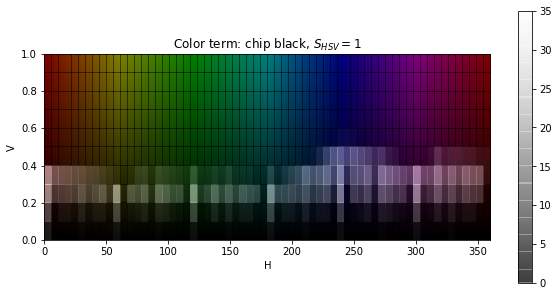

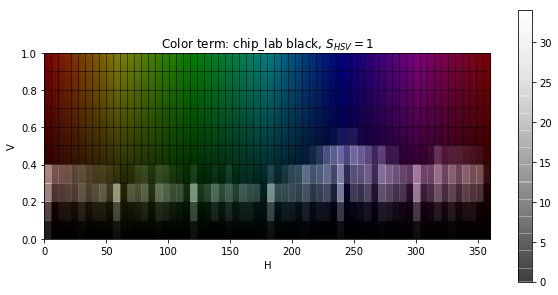

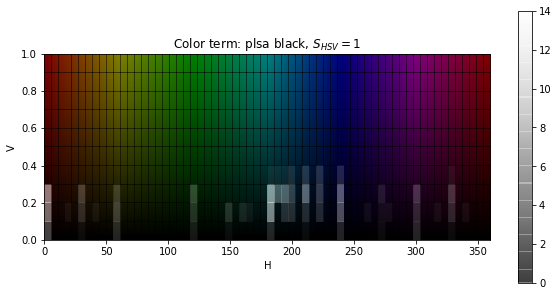

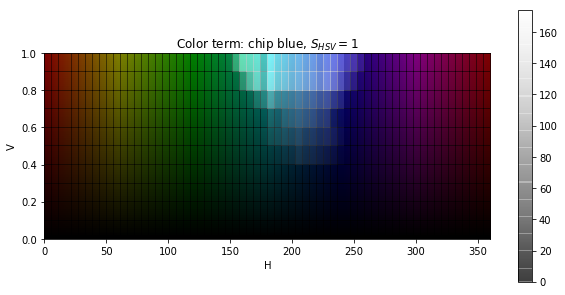

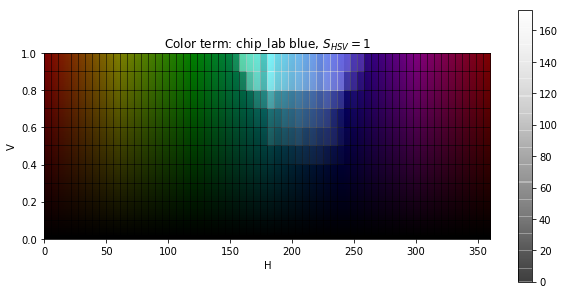

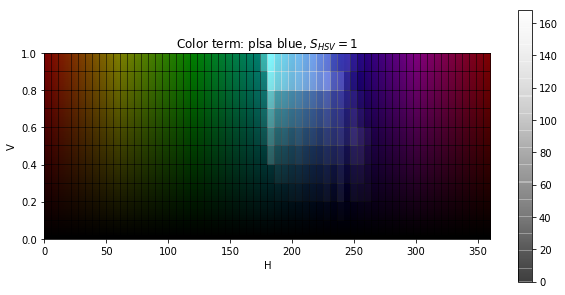

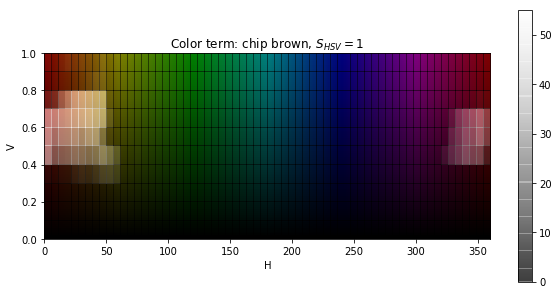

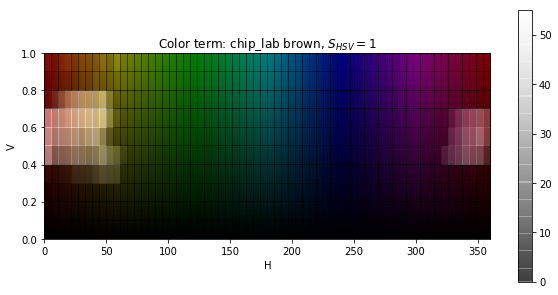

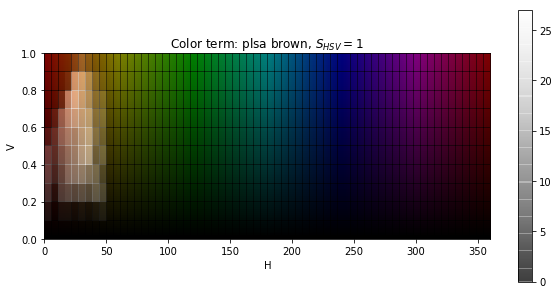

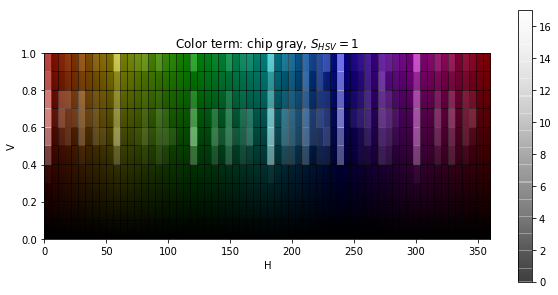

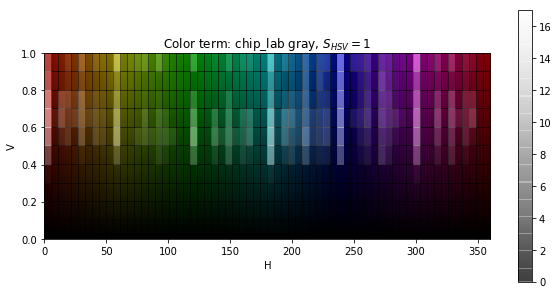

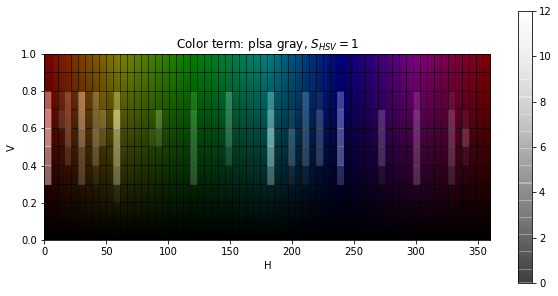

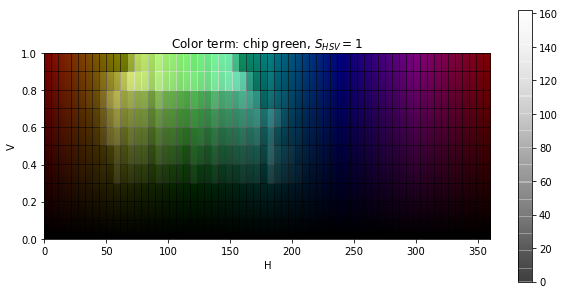

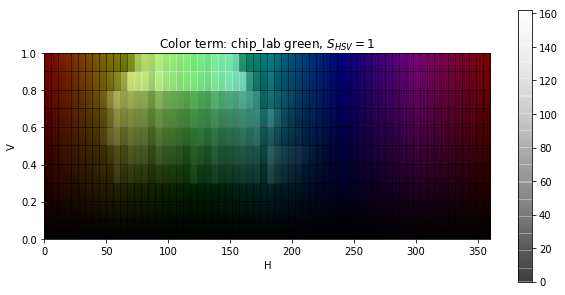

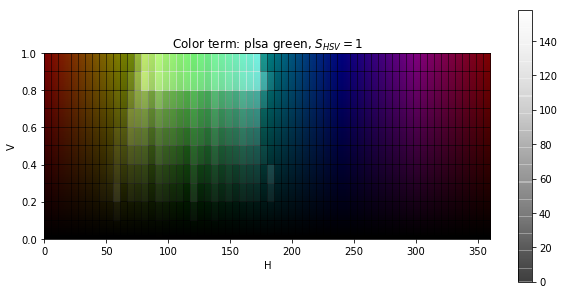

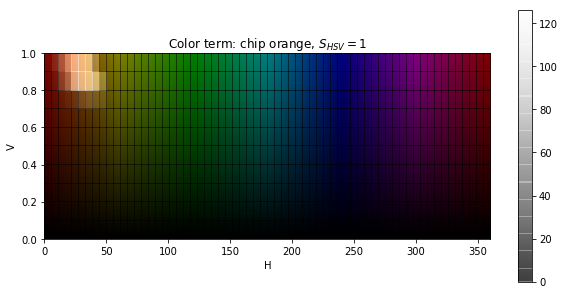

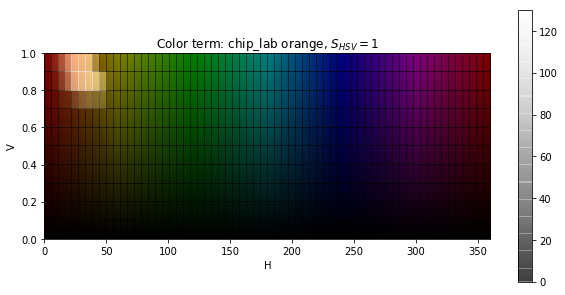

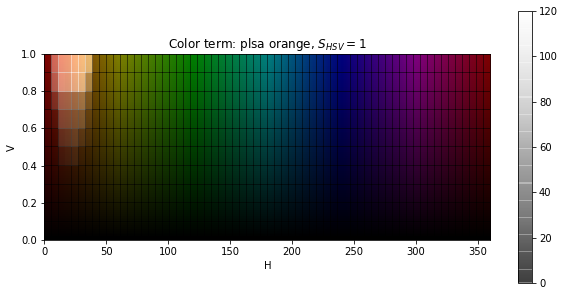

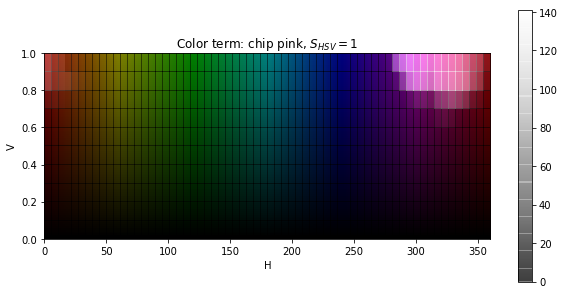

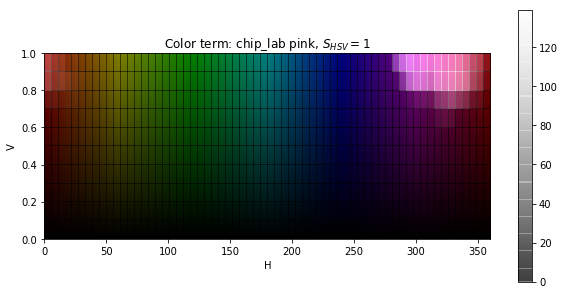

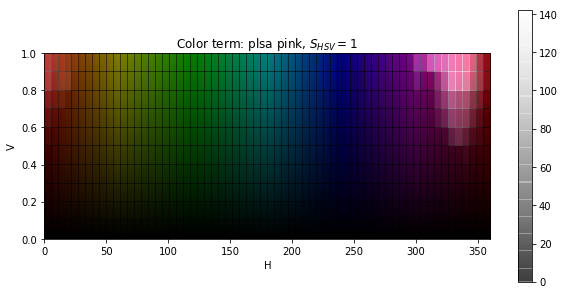

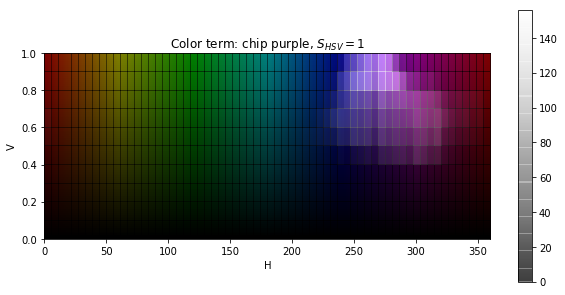

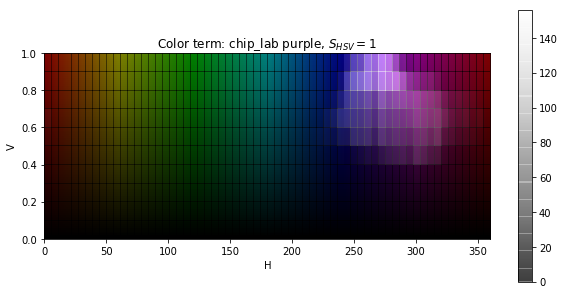

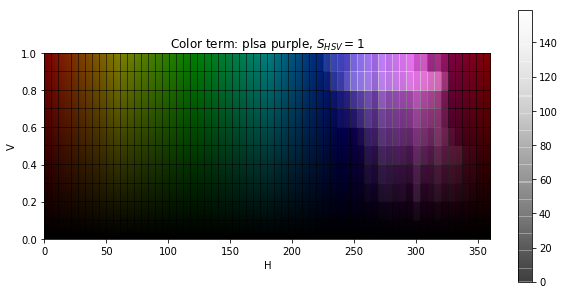

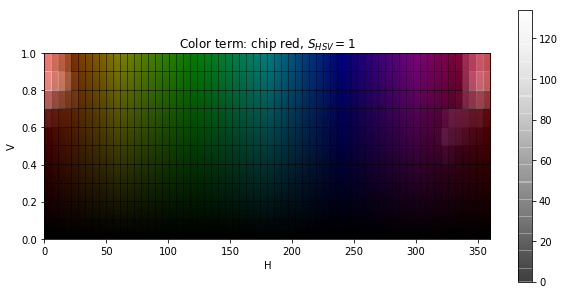

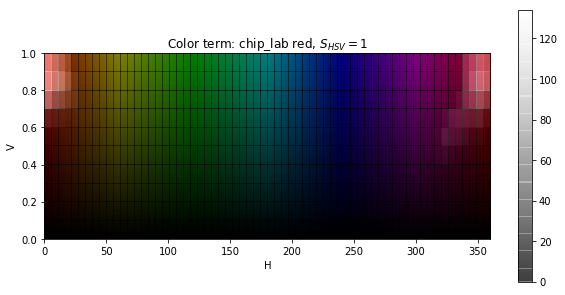

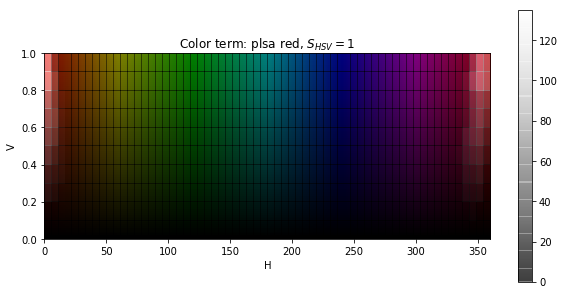

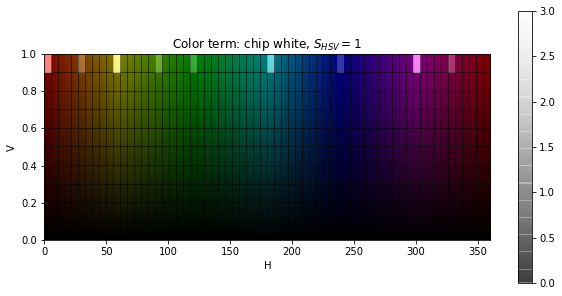

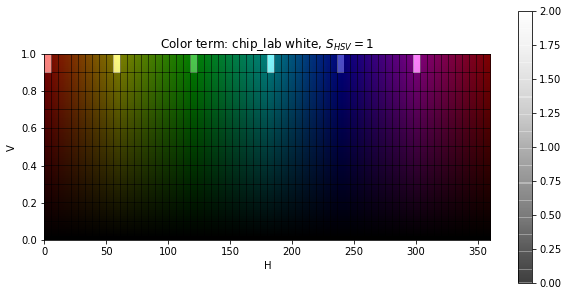

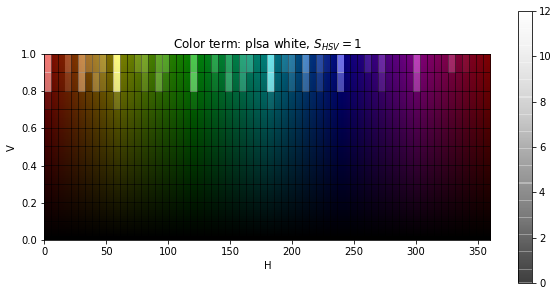

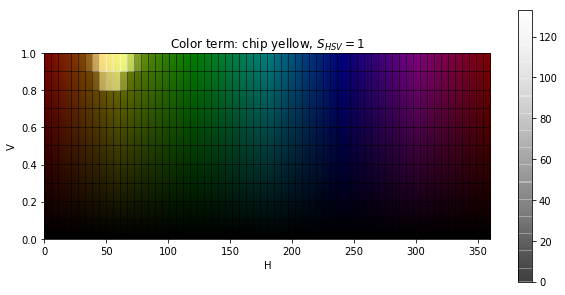

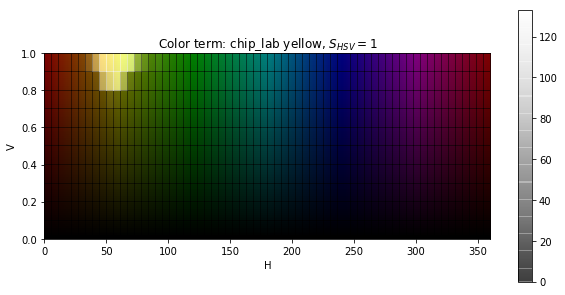

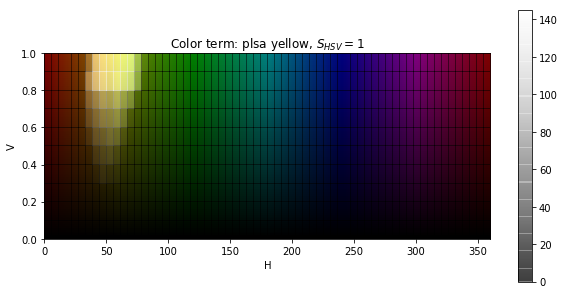

In [84]:
df_chip = pd.DataFrame(w2c_datasets['chip_w2c'], columns='r g b'.split()+preprocessing.basic_colors())
df_chip = pd.merge(
    df_chip['r g b'.split()],
    df_chip.drop('r g b'.split(), axis=1).idxmax(axis=1).rename('color'),
    left_index=True, right_index=True
            )

df_chip_lab = pd.DataFrame(w2c_datasets['chip_w2c_lab'], columns='r g b'.split()+preprocessing.basic_colors())
df_chip_lab = pd.merge(
    df_chip_lab['r g b'.split()],
    df_chip_lab.drop('r g b'.split(), axis=1).idxmax(axis=1).rename('color'),
    left_index=True, right_index=True
            )

df_plsa = pd.DataFrame(w2c_datasets['w2c'], columns='r g b'.split()+preprocessing.basic_colors())
df_plsa = pd.merge(
    df_plsa['r g b'.split()],
    df_plsa.drop('r g b'.split(), axis=1).idxmax(axis=1).rename('color'),
    left_index=True, right_index=True
            )

for c in preprocessing.basic_colors():
    visualize.plot_in_hsv_chart(
        df_chip.loc[df_chip['color'] == c]['r g b'.split()].values.tolist(),
        color_term = 'chip ' + c
        )
    visualize.plot_in_hsv_chart(
        df_chip_lab.loc[df_chip_lab['color'] == c]['r g b'.split()].values.tolist(),
        color_term = 'chip_lab ' + c
        )
    visualize.plot_in_hsv_chart(
        df_plsa.loc[df_plsa['color'] == c]['r g b'.split()].values.tolist(),
        color_term = 'plsa ' + c
        )